In [409]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [410]:
path = './traces/'# use your path
all_files = glob.glob(path + "/*.h5")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    trace.close()
    
    li.append(data)

df = pd.concat(li, axis=0, ignore_index=True)


In [411]:
print(df.head())
print(df.shape)

  type   id nb_data_items stream_id flags node_id chore_id total_data_size  \
0    3    0             0         0     1       1        0               0   
1    3    0             0         0     1       1        0               0   
2    3    1             2         0     1       1        0               0   
3    3   76             2         0     1       1        0               0   
4    3  226             2         0     1       1        0               0   

  task_class_id taskpool_id       end     begin priority  tid tcid msg_size  \
0             5           2     58693     56000       -1  NaN  NaN      NaN   
1             4           2   1347796     60284       -1  NaN  NaN      NaN   
2             1           2   8699232   1352975        0  NaN  NaN      NaN   
3             1           2  16728234   8706044        0  NaN  NaN      NaN   
4             1           2  24272737  16734689        0  NaN  NaN      NaN   

   src tpid  dst  
0  NaN  NaN  NaN  
1  NaN  NaN  NaN  

# Clean the data

In [412]:
#remove info from other traces
df_refined = df[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df_refined['exec_time'] = df['end'] - df['begin']



In [413]:
# remove unwanted values
df_refined.dropna()
df_refined = df_refined[df_refined.priority > -1]
df_refined = df_refined[df_refined.taskpool_id > -1]
print(df_refined.head())
print(df_refined.shape)

#check all the values in the df is numeric
df_refined.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

#if(df_refined.isnull().values.any()):
#    df_refined.dropna()


      begin       end taskpool_id task_class_id chore_id nb_data_items  \
2   1352975   8699232           2             1        0             2   
3   8706044  16728234           2             1        0             2   
4  16734689  24272737           2             1        0             2   
5  24278334  32289685           2             1        0             2   
6  32295483  39697575           2             1        0             2   

  total_data_size priority exec_time  
2               0        0   7346257  
3               0        0   8022190  
4               0        0   7538048  
5               0        0   8011351  
6               0        0   7402092  
(380147, 9)


begin              True
end                True
taskpool_id        True
task_class_id      True
chore_id           True
nb_data_items      True
total_data_size    True
priority           True
exec_time          True
dtype: bool

###  task_class_id and  taskpool_id are catogorical data. So it has to be transformed using dummies

In [375]:
df_refined = pd.get_dummies(df_refined, prefix='task_class_', columns=['task_class_id'], prefix_sep='')
df_refined = pd.get_dummies(df_refined, prefix='task_pool_', columns=['taskpool_id'], prefix_sep='')

/usr/local/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/usr/local/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [376]:
#df_refined.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())
# select the float columns
#df_num = df.select_dtypes(include=[np.float])
#print(df_num)
# select non-numeric columns
#df_num = df_refined.select_dtypes(exclude=[np.number])
#print(df_num)

In [377]:
#df_refined = data_refined.astype(float)
df_refined = df_refined.apply(pd.to_numeric, errors='coerce')
#print(df_refined.head())
#df_refined.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

In [314]:
#data_refined.columns[~data_refined.columns.duplicated()]
#data_refined.columns.is_unique
#data_refined.index.duplicated()
#data_refined.index = data_refined.index.where(~data_refined.index.duplicated(), data_refined.index + 10)
#data_refined.index.duplicated()

### Divide the data to training and data sets

In [378]:
train_dataset = df_refined.sample(frac=0.8, random_state=0)
test_dataset = df_refined.drop(train_dataset.index)
print(train_dataset.shape)
print(test_dataset.shape)

(304118, 14)
(76029, 14)


In [379]:
#train_dataset.head()
#train_dataset.isnull().values.any()
#train_dataset.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

In [380]:
#train_dataset.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

## Data description

In [381]:
#sns.pairplot(train_dataset[['exec_time', 'begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']], diag_kind='kde')
#sns.pairplot(train_dataset[['exec_time','total_data_size', 'chore_id', 'nb_data_items', 'priority']], diag_kind='kde')



In [383]:
#train_dataset.transpose().describe()

## Divide the data into trainig features and labels

In [384]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('exec_time')
test_labels = test_features.pop('exec_time')

In [385]:
train_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
begin,304118.0,2.336290e+11,2.220619e+11,113754.0,5.845145e+10,1.601811e+11,3.435423e+11,8.305551e+11
end,304118.0,2.336422e+11,2.220658e+11,843836.0,5.845883e+10,1.601857e+11,3.435589e+11,8.305585e+11
chore_id,304118.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
nb_data_items,304118.0,2.906684e+00,2.964289e-01,0.0,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
total_data_size,304118.0,8.068626e+05,1.177754e+06,0.0,0.000000e+00,0.000000e+00,1.280000e+06,1.024000e+07
priority,304118.0,5.404704e+04,9.814905e+04,0.0,4.704000e+03,1.593600e+04,5.315725e+04,1.000000e+06
task_class_0,304118.0,7.069624e-04,2.657941e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
task_class_1,304118.0,6.023320e-02,2.379188e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
task_class_2,304118.0,3.074465e-02,1.726253e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
task_class_3,304118.0,9.082560e-01,2.886647e-01,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [350]:
#train_features.head()

,begin,end,chore_id,nb_data_items,total_data_size,priority,task_class_0,task_class_1,task_class_2,task_class_3,task_class_4,task_pool_2,task_pool_4
81342,435261423394,435278316211,0,3,0,15385,0,0,0,1,0,0,1
67905,183151088802,183167948493,0,3,0,65204,0,0,0,1,0,0,1
223688,48842699245,48844846874,0,3,0,49288,0,0,0,1,0,0,1
154267,794931042942,794947635497,0,3,2560000,181,0,0,0,1,0,0,1
92701,660981551892,660998483235,0,3,0,4256,0,0,0,1,0,0,1


# ------------Build the univariate model using only data--------------------------

In [351]:
total_data_size = np.array(train_features['total_data_size'])
data_only_normalizer = layers.Normalization(input_shape=[1,], axis=None)
data_only_normalizer.adapt(total_data_size)

In [352]:

data_only_model = tf.keras.Sequential([
    data_only_normalizer,
    layers.Dense(units=1)
])

data_only_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_28 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [330]:
data_only_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error', metrics=["accuracy"])

## Train the univariate model

In [331]:

history = data_only_model.fit(
    train_features['total_data_size'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

## visualize the univariate model

In [332]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,13145193.0,0.0,13102319.0,0.0,95
96,13144415.0,0.0,13101557.0,0.0,96
97,13143617.0,0.0,13100772.0,0.0,97
98,13142840.0,0.0,13100017.0,0.0,98
99,13142088.0,0.0,13099242.0,0.0,99


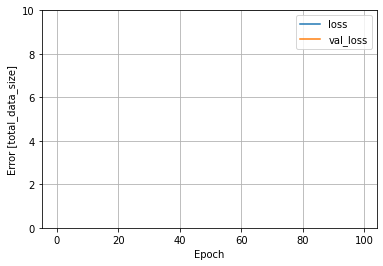

In [333]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [total_data_size]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

# -------------------Build the multi variate full model------------------------------

## select the required features from the list

In [389]:
#train_features.head()

In [391]:
## for the time being select only total_data_size, priority, diff task_classes and diff taskpools

#train_features = train_features.drop('end', 1)
#train_features = train_features.drop('end', 1)
train_features = train_features.drop(['chore_id', 'begin', 'end'], axis = 1)
train_features.head()

,nb_data_items,total_data_size,priority,task_class_0,task_class_1,task_class_2,task_class_3,task_class_4,task_pool_2,task_pool_4
81342,3,0,15385,0,0,0,1,0,0,1
67905,3,0,65204,0,0,0,1,0,0,1
223688,3,0,49288,0,0,0,1,0,0,1
154267,3,2560000,181,0,0,0,1,0,0,1
92701,3,0,4256,0,0,0,1,0,0,1


In [398]:
full_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [399]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [400]:
full_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.Accuracy()])
print(full_model.metrics_names)

[]


## Train the model

In [401]:
history = full_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [402]:
full_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_30 (Normaliza  (None, 10)               21        
 tion)                                                           
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 32
Trainable params: 11
Non-trainable params: 21
_________________________________________________________________


In [403]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,accuracy,val_loss,val_mean_squared_error,val_accuracy,epoch
95,13145175.0,5.353163e+14,0.0,13102349.0,5.359670e+14,0.0,95
96,13144430.0,5.352971e+14,0.0,13101573.0,5.359475e+14,0.0,96
97,13143613.0,5.352766e+14,0.0,13100801.0,5.359267e+14,0.0,97
98,13142825.0,5.352552e+14,0.0,13100032.0,5.359061e+14,0.0,98
99,13142037.0,5.352338e+14,0.0,13099257.0,5.358862e+14,0.0,99


## Test the Model 

In [405]:
#test_results = {}
#test_results['full_model'] = full_model.evaluate(
#    test_features, test_labels, verbose=0)
#loss, acc = full_model.evaluate(test_features, test_labels, verbose=2)
#print(test_results['full_model'])

loss = full_model.evaluate(test_features, test_labels, batch_size=128)
print(loss)

ValueError: in user code:

    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "normalization_30" (type Normalization).
    
    Dimensions must be equal, but are 13 and 10 for '{{node sequential_12/normalization_30/sub}} = Sub[T=DT_FLOAT](sequential_12/Cast, sequential_12/normalization_30/sub/y)' with input shapes: [?,13], [1,10].
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 13), dtype=float32)


## checkpoint the model

In [67]:
checkpoint_path = "./full_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## Train again from the checkpoint

In [68]:
full_model.fit(train_features, 
          train_labels,  
          epochs=10,
          validation_data=(train_features, train_labels),
          callbacks=[cp_callback]) 

Epoch 1/10
2203/2211 [============================>.] - ETA: 0s - loss: 6258607.5000
Epoch 1: saving model to ./full_model.ckpt
2211/2211 [==============================] - 6s 3ms/step - loss: 6256079.5000 - val_loss: 6255974.0000
Epoch 2/10
2196/2211 [============================>.] - ETA: 0s - loss: 6262878.5000
Epoch 2: saving model to ./full_model.ckpt
2211/2211 [==============================] - 6s 3ms/step - loss: 6255860.0000 - val_loss: 6255759.0000
Epoch 3/10
2209/2211 [============================>.] - ETA: 0s - loss: 6253822.0000
Epoch 3: saving model to ./full_model.ckpt
2211/2211 [==============================] - 6s 3ms/step - loss: 6255645.5000 - val_loss: 6255526.5000
Epoch 4/10
2197/2211 [============================>.] - ETA: 0s - loss: 6254022.0000
Epoch 4: saving model to ./full_model.ckpt
2211/2211 [==============================] - 6s 3ms/step - loss: 6255423.5000 - val_loss: 6255318.5000
Epoch 5/10
2189/2211 [============================>.] - ETA: 0s - loss: 6247

In [24]:
os.listdir(checkpoint_dir)

['trace.ipynb',
 'checkpoint',
 'model-Copy1.ipynb',
 'Untitled.ipynb',
 'demo_8.otf2',
 'model-working.ipynb',
 'demo_8',
 'model_keras.ipynb',
 'sample.ipynb',
 'CMakeError.log',
 'full_model.ckpt.data-00000-of-00001',
 'demo_8.vsettings',
 'train',
 'full_model.ckpt.index',
 '.ipynb_checkpoints',
 'dpotrf-1.prof.h5',
 'Archive.zip',
 'demo_8.def',
 'dpotrf-0.prof.h5']

## Save the model

In [69]:
full_model.save('./full_model')

2022-04-05 18:08:39.915580: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./full_model/assets


## Train using DNN

In [406]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [407]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_31 (Normaliza  (None, 10)               21        
 tion)                                                           
                                                                 
 dense_15 (Dense)            (None, 64)                704       
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


In [408]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

KeyboardInterrupt: 

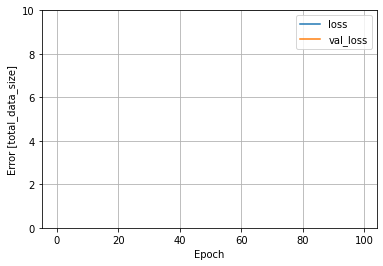

In [364]:
plot_loss(history)